In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
log = 0

In [2]:
class Generator(nn.Module):
    def __init__(self, latent):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent, 32*7*7),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 3, stride=1, padding=1),
            nn.Tanh() 
        )
    def forward(self, x):
        out = self.fc(x).view(x.shape[0], 32, 7, 7)
        out = self.conv(out)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def block(in_ch, out_ch):
            layer = [
                nn.Conv2d(in_ch, out_ch, 3, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(0.2, inplace=True),
            ]
            return layer
        self.conv = nn.Sequential(
            *block(1,16),
            *block(16, 32),
            *block(32, 64),
        )
        self.fc = nn.Sequential(nn.Linear(64*2*2, 1), nn.Sigmoid())
    def forward(self, x):
        out = self.conv(x).view(x.shape[0], -1)
        out = self.fc(out)
        return out

In [3]:
train_data = torchvision.datasets.MNIST(root='../dataset/', download=True, train=True, transform=torchvision.transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

In [4]:
latent = 64
lr = 0.001
epochs = 20

In [5]:
G = Generator(latent)
D = Discriminator()
criterion = nn.BCELoss()
optimizer_G = torch.optim.RMSprop(G.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(D.parameters(), lr=lr)

In [6]:
log = log + 1
writer = SummaryWriter(log_dir='dcnn/'+str(log))
num = 0
test = torch.normal(0, 1, (32, latent))
for epoch in range(epochs):
    avg_loss_g = 0.0
    avg_loss_d = 0.0
    for i, (real_img, _) in enumerate(train_iter):
        batch_size = real_img.shape[0]
        
        real_label = torch.ones(batch_size, 1)
        fake_label = torch.zeros(batch_size, 1)
        
        # 训练判别器
        d_real = D(real_img)
        d_real_loss = criterion(d_real, real_label)
        
        z = torch.normal(0, 1, (batch_size, latent))
        fake_img = G(z)
        d_fake = D(fake_img)
        d_fake_loss = criterion(d_fake, fake_label)
        
        optimizer_D.zero_grad()
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # 训练生成器
        z = torch.normal(0, 1, (batch_size, latent))
        fake_img = G(z)
        d_fake = D(fake_img)
        g_loss = criterion(d_fake, real_label)
        
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
        avg_loss_g += g_loss.item()
        avg_loss_d += d_loss.item()
        
        if (i+1) % 100 == 0:
            print("Epoch:{}, Loss_D:{}, Loss_G:{}".format(epoch, avg_loss_d/100, avg_loss_g/100))
            writer.add_scalar('Loss_D', avg_loss_d/100, num)
            writer.add_scalar('Loss_G', avg_loss_g/100, num)
            avg_loss_g = 0.0
            avg_loss_d = 0.0
            num += 1
    with torch.no_grad():
        s = "Epoch-"+str(epoch)
        show = torch.clamp(G(test), 0, 1)
        writer.add_images(s, show, 0)
writer.close()

Epoch:0, Loss_D:1.2923063069581986, Loss_G:0.8715248972177505
Epoch:0, Loss_D:1.2252220833301544, Loss_G:0.8858872091770172
Epoch:0, Loss_D:1.1880201625823974, Loss_G:0.9403862822055816
Epoch:0, Loss_D:1.1503397953510284, Loss_G:1.000281991958618
Epoch:1, Loss_D:1.0974978071451187, Loss_G:1.0759896692633628
Epoch:1, Loss_D:1.0539874160289764, Loss_G:1.1371852385997772
Epoch:1, Loss_D:1.0329025620222092, Loss_G:1.180043706893921
Epoch:1, Loss_D:0.9943048256635666, Loss_G:1.231670112013817
Epoch:2, Loss_D:0.9700254577398301, Loss_G:1.3036437118053437
Epoch:2, Loss_D:0.9333375543355942, Loss_G:1.365861603617668
Epoch:2, Loss_D:0.9324185431003571, Loss_G:1.390927066206932
Epoch:2, Loss_D:0.9266565871238709, Loss_G:1.4229617846012115
Epoch:3, Loss_D:0.8929119223356247, Loss_G:1.4801906883716582
Epoch:3, Loss_D:0.9017980432510376, Loss_G:1.4619097673892976
Epoch:3, Loss_D:0.8991804713010788, Loss_G:1.4575238847732543
Epoch:3, Loss_D:0.8909874248504639, Loss_G:1.5032166826725006
Epoch:4, Loss

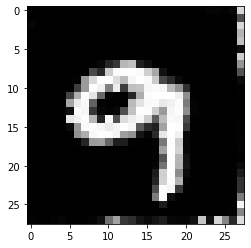

In [11]:
import matplotlib.pyplot as plt

G.eval()
z = torch.normal(0, 1, (1, latent))
image = G(z)
img = torchvision.transforms.ToPILImage()(image.reshape(28,28))
plt.imshow(img,cmap='gray')